In [1]:
import pandas as pd

In [4]:
df=pd.read_csv("C:\\Users\\ANESTHESIA\\Downloads\\AAPL.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [6]:
df1=df.reset_index()['Close']
df1.head()

0    0.128348
1    0.121652
2    0.112723
3    0.115513
4    0.118862
Name: Close, dtype: float64

In [7]:
df1=df1[7000:]

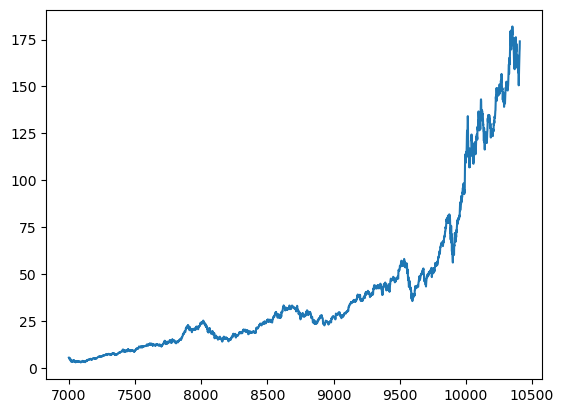

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
import numpy as np
df1.head()

7000    5.414643
7001    5.451786
7002    5.319286
7003    5.012857
7004    4.995714
Name: Close, dtype: float64

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.0146291 ]
 [0.01483635]
 [0.01409703]
 ...
 [0.92640219]
 [0.93415815]
 [0.95569627]]


In [11]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(2215, 1194)

In [12]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)

(2114, 100)
(2114,)


(None, None)

In [13]:
print(X_test.shape), print(ytest.shape)

(1093, 100)
(1093,)


(None, None)

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#reshaping it into 3 dimensions, since the  last 2 dim will be as a input in LSTM
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
34/34 [==============================] - 37s 477ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2/100
34/34 [==============================] - 11s 331ms/step - loss: 4.1008e-05 - val_loss: 0.0035
Epoch 3/100
34/34 [==============================] - 12s 344ms/step - loss: 3.0411e-05 - val_loss: 0.0027
Epoch 4/100
34/34 [==============================] - 12s 370ms/step - loss: 3.3080e-05 - val_loss: 0.0040
Epoch 5/100
34/34 [==============================] - 12s 345ms/step - loss: 3.0201e-05 - val_loss: 0.0036
Epoch 6/100
34/34 [==============================] - 11s 337ms/step - loss: 3.2447e-05 - val_loss: 0.0036
Epoch 7/100
34/34 [==============================] - 13s 375ms/step - loss: 2.6942e-05 - val_loss: 0.0027
Epoch 8/100
34/34 [==============================] - 6s 170ms/step - loss: 2.7557e-05 - val_loss: 0.0032
Epoch 9/100
34/34 [==============================] - 5s 155ms/step - loss: 2.7068e-05 - val_loss: 0.0040
Epoch 10/100
34/34 [==============================] 

In [16]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

35/35 [==============================] - 1s 38ms/step


20.88165217697663

In [17]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

94.88155842674432

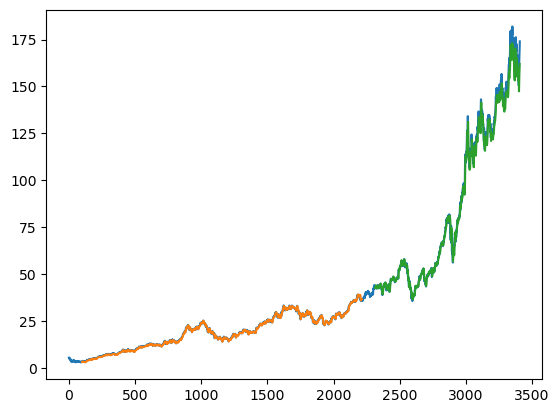

<Figure size 640x480 with 0 Axes>

In [18]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
plt.savefig('plot.jpg')
# model.save("saved_model.h5")

In [19]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 853)

In [20]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.2738417907332054,
 0.26562550061479057,
 0.2686665155873653,
 0.2772873317506052,
 0.27525070732911716,
 0.26964297912178464,
 0.25527493358363973,
 0.25256871360148603,
 0.24499411434636348,
 0.2514248609415914,
 0.25438216182204626,
 0.24368285024169956,
 0.23129563646976664,
 0.23101665087409218,
 0.22475328782451598,
 0.2280035405988907,
 0.22747346852509162,
 0.23681967290427325,
 0.23488068423456243,
 0.23352757145357383,
 0.24223210728875716,
 0.2308911104249416,
 0.2281430417664632,
 0.21945247222952527,
 0.22100087883336247,
 0.21964776605237388,
 0.22030340089461756,
 0.22288405252850316,
 0.21525364387863397,
 0.21310542298694668,
 0.2160766845858235,
 0.2088508019807793,
 0.20318728111817075,
 0.19467804468565947,
 0.1892377223432728,
 0.20366156611651726,
 0.20223869996183066,
 0.20235030201185336,
 0.20445669654650997,
 0.2047077830246346,
 0.1827651326515436,
 0.19123250366825967,
 0.1907721626488645,
 0.19470594938303276,
 0.19827703084958315,
 0.19896057038920018,
 

In [23]:
pip install dash

In [2]:
pip install yfinance

     ---------------------------------------- 0.0/84.6 kB ? eta -:--:--
     ---------------------------------------- 84.6/84.6 kB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/64.9 kB ? eta -:--:--
     ---------------------------------------- 64.9/64.9 kB 3.6 MB/s eta 0:00:00
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB 8.3 MB/s eta 0:00:01
     ------- -------------------------------- 0.5/3.0 MB 8.5 MB/s eta 0:00:01
     ------------- -------------------------- 1.0/3.0 MB 8.8 MB/s eta 0:00:01
     ------------------ --------------------- 1.4/3.0 MB 8.9 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/3.0 MB 9.4 MB/s eta 0:00:01
     ----------------------------- ---------- 2.2/3.0 MB 9.4 MB/s eta 0:00:01
     ------------------------------------- -- 2.8/3.0 MB 10.4 MB/s eta 0:00:01
     ------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [1]:
import dash
import dash_core_components as  dcc
import dash_html_components as html
from datetime import datetime as dt
import yfinance as yf
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
# model
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
from sklearn.svm import SVR


def get_stock_price_fig(df):

    fig = px.line(df,
                  x="Date",
                  y=["Close", "Open"],
                  title="Closing and Opening Price vs Date")

    return fig


def get_more(df):
    df['EWA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    fig = px.scatter(df,
                     x="Date",
                     y="EWA_20",
                     title="Exponential Moving Average vs Date")
    fig.update_traces(mode='lines+markers')
    return fig


app = dash.Dash(
    __name__,
    external_stylesheets=[
        "https://fonts.googleapis.com/css2?family=Roboto&display=swap"
    ])
server = app.server
# html layout of site
app.layout = html.Div(
    [
        html.Div(
            [
                # Navigation
                html.P("Welcome to the Stock Prediction App!", className="start"),
                html.Div([
                    html.P("Input stock code: "),
                    html.Div([
                        dcc.Input(id="dropdown_tickers", type="text"),
                        html.Button("Submit", id='submit'),
                    ],
                             className="form")
                ],
                         className="input-place"),
                html.Div([
                    dcc.DatePickerRange(id='my-date-picker-range',
                                        min_date_allowed=dt(1995, 8, 5),
                                        max_date_allowed=dt.now(),
                                        initial_visible_month=dt.now(),
                                        end_date=dt.now().date()),
                ],
                         className="date"),
                html.Div([
                    html.Button(
                        "Stock Price", className="stock-btn", id="stock"),
                    html.Button("Indicators",
                                className="indicators-btn",
                                id="indicators"),
                    dcc.Input(id="n_days",type="text",
                              placeholder="number of days"),
                    html.Button(
                        "Forecast", className="forecast-btn", id="forecast")
                ],
                         className="buttons"),
                # here
            ],
            className="nav"),

        # content
        html.Div(
            [
                html.Div(
                    [  # header
                        html.Img(id="logo"),
                        html.P(id="ticker")
                    ],
                    className="header"),
                html.Div(id="description", className="decription_ticker"),
                html.Div([], id="graphs-content"),
                html.Div([], id="main-content"),
                html.Div([], id="forecast-content")
            ],
            className="content"),
    ],
    className="container")


# callback for company info
@app.callback([
    Output("description", "children"),
    Output("logo", "src"),
    Output("ticker", "children"),
    Output("stock", "n_clicks"),
    Output("indicators", "n_clicks"),
    Output("forecast", "n_clicks")
], [Input("submit", "n_clicks")], [State("dropdown_tickers", "value")])
def update_data(n, val):  # input parameter(s)
    if n == None:
        return "Hey there! Please enter a legitimate stock code to get details.", None, None, None
        # raise PreventUpdate
    else:
        if val == None:
            raise PreventUpdate
        else:
            ticker = yf.Ticker(val)
            inf = ticker.info
            df = pd.DataFrame().from_dict(inf, orient="index").T
            df[['logo_url', 'shortName', 'longBusinessSummary']]
            return df['longBusinessSummary'].values[0], df['logo_url'].values[
                0], df['shortName'].values[0], None, None, None


# callback for stocks graphs
@app.callback([
    Output("graphs-content", "children"),
], [
    Input("stock", "n_clicks"),
    Input('my-date-picker-range', 'start_date'),
    Input('my-date-picker-range', 'end_date')
], [State("dropdown_tickers", "value")])
def stock_price(n, start_date, end_date, val):
    if n == None:
        return [""]
        #raise PreventUpdate
    if val == None:
        raise PreventUpdate
    else:
        if start_date != None:
            df = yf.download(val, str(start_date), str(end_date))
        else:
            df = yf.download(val)

    df.reset_index(inplace=True)
    fig = get_stock_price_fig(df)
    return [dcc.Graph(figure=fig)]


# callback for indicators
@app.callback([Output("main-content", "children")], [
    Input("indicators", "n_clicks"),
    Input('my-date-picker-range', 'start_date'),
    Input('my-date-picker-range', 'end_date')
], [State("dropdown_tickers", "value")])
def indicators(n, start_date, end_date, val):
    if n == None:
        return [""]
    if val == None:
        return [""]

    if start_date == None:
        df_more = yf.download(val)
    else:
        df_more = yf.download(val, str(start_date), str(end_date))

    df_more.reset_index(inplace=True)
    fig = get_more(df_more)
    return [dcc.Graph(figure=fig)]


# callback for forecast
@app.callback([Output("forecast-content", "children")],
              [Input("forecast", "n_clicks")],
              [State("n_days", "value"),
               State("dropdown_tickers", "value")])
def forecast(n, n_days, val):
    if n == None:
        return [""]
    if val == None:
        raise PreventUpdate
    fig = model.predict(val, int(n_days) + 1)
    return [dcc.Graph(figure=fig)]


if __name__ == '__main__':
    app.run_server(debug=False)

C:\Users\ANESTHESIA\AppData\Local\Temp\ipykernel_27428\1721569910.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as  dcc
C:\Users\ANESTHESIA\AppData\Local\Temp\ipykernel_27428\1721569910.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


[2024-09-02 16:30:04,919] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\ANESTHESIA\anaconda3\envs\tf-new\lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\ANESTHESIA\anaconda3\envs\tf-new\lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\ANESTHESIA\anaconda3\envs\tf-new\lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\ANESTHESIA\anaconda3\envs\tf-new\lib\site-packages\flask\app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
  File "C:\Users\ANESTHESIA\anaconda3\envs\tf-new\lib\site-packages\dash\dash.py", line 1373, in dispatch
    ctx.run(
  File "C:\Users\ANESTHESIA\anaconda3\envs\tf-new\lib\site-packages\dash\_callback.